In [1]:
import pandas as pd

# data = pd.read_parquet('announcement/processed_LLM_data_test_5_5_10_2k_summary_with_industry.parquet')
data = pd.read_csv('industry_data_test.csv')
data

,Unnamed: 0.1,Unnamed: 0,ts_code,trade_date,name,open,low,high,close,change,...,amount,pe,pb,float_mv,total_mv,industry_news,len_token,log_r,industry,content
0,20,1151,801738.SI,2023-07-04 09:00:00,电网设备,4082.66,4035.19,4136.93,4088.95,10.95,...,1474891.0,18.63,2.43,56552772.0,1.075443e+08,2023-07-03 13:06:44 新闻:A股电力设备板块午后走强，上能电气20CM涨停...,60,-0.006904,电网设备,现在是2023-07-04 09:00:00\n2023-07-03 13:06:44 新闻...
1,24,537,801054.SI,2024-01-12 09:00:00,小金属,14357.28,14219.33,14531.86,14302.80,-87.06,...,511537.0,23.24,2.41,21559005.0,4.281217e+07,2024-01-11 13:15:22 新闻:【小金属概念异动拉升 中矿资源涨停】 小金属概...,74,-0.019166,小金属,现在是2024-01-12 09:00:00\n2024-01-11 13:15:22 新闻...
2,52,1146,857355.SI,2023-06-27 09:00:00,光伏加工设备,2574.28,2559.56,2688.66,2603.44,28.23,...,305271.0,25.85,4.95,11633910.0,2.332863e+07,2023-06-26 13:12:43 新闻:【光伏设备板块午后震荡走高】 光伏设备板块午后...,70,0.055202,光伏加工设备,现在是2023-06-27 09:00:00\n2023-06-26 13:12:43 新闻...
3,83,1135,801219.SI,2023-06-08 09:00:00,酒店餐饮,2832.62,2793.58,2892.74,2866.17,38.50,...,358486.0,225.44,3.11,4844327.0,1.087033e+07,2023-06-07 13:14:46 新闻:A股酒店餐饮股午后异动走强，西安饮食涨超4%，...,56,0.002063,酒店餐饮,现在是2023-06-08 09:00:00\n2023-06-07 13:14:46 新闻...
4,84,1151,801219.SI,2023-07-04 09:00:00,酒店餐饮,2787.72,2756.36,2844.63,2808.33,2.24,...,196234.0,220.88,3.04,4754383.0,1.068310e+07,2023-07-03 13:23:32 新闻:A股酒店餐饮板块午后继续走强，君亭酒店涨超11...,56,-0.011284,酒店餐饮,现在是2023-07-04 09:00:00\n2023-07-03 13:23:32 新闻...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492,4748,1304,801737.SI,2024-02-21 09:00:00,电池,11638.43,11548.02,12173.08,11905.10,183.23,...,1920796.0,17.46,2.38,91170337.0,1.686764e+08,2024-02-20 14:07:37 新闻:A股BC电池板块震荡上行，罗博特科此前涨停，英...,57,0.032159,电池,现在是2024-02-21 09:00:00\n2024-02-20 14:07:37 新闻...
493,4749,1337,801737.SI,2024-04-10 09:00:00,电池,14080.64,13722.13,14193.83,13875.01,-256.48,...,3649803.0,21.01,2.67,104961278.0,1.966700e+08,2024-04-09 13:20:23 新闻:固态电池概念股持续爆发，天赐材料午后涨停，德福...,88,NaN,电池,现在是2024-04-10 09:00:00\n2024-04-09 13:20:23 新闻...
494,4777,453,850813.SI,2023-09-07 09:00:00,半导体材料,6634.03,6428.69,6658.16,6434.04,-263.54,...,211039.0,66.76,3.65,5662463.0,9.486319e+06,2023-09-06 13:29:05 新闻:【半导体及元件板块午后继续走高】 半导体及元件...,71,-0.013604,半导体材料,现在是2023-09-07 09:00:00\n2023-09-06 13:29:05 新闻...
495,4778,472,850813.SI,2023-10-12 09:00:00,半导体材料,6355.19,6247.28,6420.29,6373.35,32.16,...,223514.0,66.65,3.62,10573289.0,2.374171e+07,2023-10-12 02:31:26 新闻:【行业复苏可期 半导体板块走势回暖】据上证报，...,143,-0.042683,半导体材料,现在是2023-10-12 09:00:00\n2023-10-12 02:31:26 新闻...


In [2]:
print(data['content'][1])

现在是2024-01-12 09:00:00
2024-01-11 13:15:22 新闻:【小金属概念异动拉升 中矿资源涨停】 小金属概念异动拉升，中矿资源涨停，天齐锂业、永兴材料涨超5%，赣锋锂业、西藏矿业、融捷股份等跟涨。


In [3]:
print(data['log_r'].min())
print(data['log_r'].max())

-0.1141180347138611
0.1750961875736836


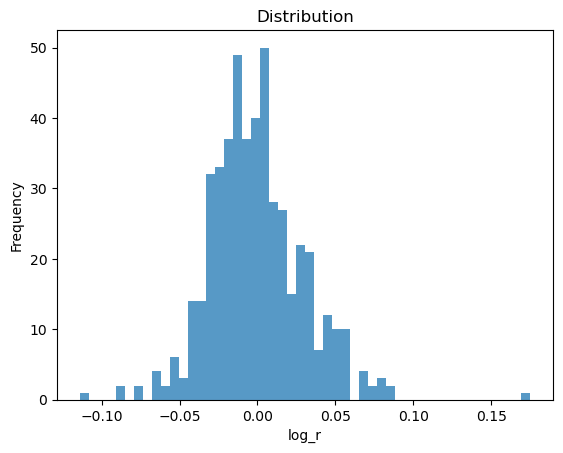

sigma: 0.03, mean: -0.001, variance: 0.001


In [4]:
import matplotlib.pyplot as plt

plt.hist(data['log_r'], bins=50, alpha=0.75)
plt.title('Distribution')
plt.xlabel('log_r')
plt.ylabel('Frequency')
plt.show()

sigma = round(data['log_r'].std(), 3)
mean = round(data['log_r'].mean(), 3)
variance = round(data['log_r'].var(), 3)

print(f'sigma: {sigma}, mean: {mean}, variance: {variance}')

In [5]:
data['label'], bins = pd.qcut(data['log_r'], 5, labels=False, retbins=True)

# Printing if there are any null values in 'log_r'
print(data['log_r'].isnull().any())

# Printing the rows where 'log_r' is null
print(data[data['log_r'].isnull()])

# Printing the bin ranges
print("Bin ranges:")
for i in range(len(bins) - 1):
    print(f"Bin {i}: {bins[i]} to {bins[i + 1]}")

True
     Unnamed: 0.1  Unnamed: 0    ts_code           trade_date   name  \
7              87        1338  801219.SI  2024-04-11 09:00:00   酒店餐饮   
25            269         593  852121.SI  2024-04-11 09:00:00     酒店   
146          1464         592  850382.SI  2024-04-10 09:00:00    氟化工   
208          2304         594  801180.SI  2024-04-12 09:00:00    房地产   
276          2826         592  851811.SI  2024-04-10 09:00:00   住宅开发   
408          3997         592  801181.SI  2024-04-10 09:00:00  房地产开发   
493          4749        1337  801737.SI  2024-04-10 09:00:00     电池   

         open       low      high     close  change  ...     pe    pb  \
7     2063.78   2038.60   2189.79   2162.14   72.53  ...  42.57  2.29   
25    2998.29   2968.93   3193.23   3158.34  123.49  ...  32.81  1.92   
146   5341.69   5176.56   5382.26   5207.21 -177.17  ...  52.11  3.43   
208   1863.70   1825.22   1873.75   1825.59  -45.27  ...  12.04  0.58   
276   2167.82   2077.98   2176.47   2098.43  -74.20  

In [6]:
data['label'].describe()

count    490.000000
mean       0.500000
std        0.500511
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
Name: label, dtype: float64

In [7]:
import pandas as pd
import json
from tqdm import tqdm
from transformers import AutoTokenizer
from concurrent.futures import ThreadPoolExecutor


def process_row(row):
    try:
        stock_mapping = {
            "600031.SH": "三一重工",
            "600036.SH": "招商银行",
            "600050.SH": "中国联通",
            "600104.SH": "上汽集团",
            "600346.SH": "恒力石化",
            "600570.SH": "恒生电子",
            "600887.SH": "伊利股份",
            "601390.SH": "中国中铁",
            "603160.SH": "汇项科技",
            "601668.SH": "中国建筑"
        }
        # stock = stock_mapping[row['symbol']]
        name = row['name']
        # prompt = f"请根据以下新闻文本，预测{name}股票的对数收益率属于以下哪一类别 ( 极度负面 / 负面 / 中性 / 正面 / 极度正面 )"
        prompt = f"请根据以下新闻文本，预测{name}行业的3天（短期）后对数收益率属于以下哪一类别：( 极度负面 / 负面 / 中性 / 正面 / 极度正面 )"
        # label_mapping = {0: "极度负面", 1: "负面", 2: "中性", 3: "正面", 4: "极度正面"}
        # label_mapping = {0: "负面", 1:正面中面"}
        label_mapping = {0: "负面", 1: "正面"}
        label = label_mapping[row['label']]

        return {
            "prompt": prompt,
            "content": row['content'],
            "label": label,
            "time":  str(row['time']),
            "log_r": str(row['log_r'])
            # "token": token
        }
    except Exception as e:
        print(f"Error processing row: {e}")
        return None


def generate_dataset(df, max_samples=32):
    df_subset = df.head(max_samples)
    results = []
    with ThreadPoolExecutor(max_workers=50) as executor:
        futures = [executor.submit(process_row, row) for _, row in df_subset.iterrows()]
        for future in tqdm(futures, total=len(futures), desc="Processing rows"):
            result = future.result()
            if result:
                results.append(result)

    return results


processed_data = generate_dataset(data, max_samples=1000000)
output_file_path = 'ft_data_industry_test.json'
with open(output_file_path, 'w', encoding='utf-8') as f:
    json.dump(processed_data, f, ensure_ascii=False, indent=2)

Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error processing row: 'symbol'
Error pr

Processing rows: 100%|██████████| 497/497 [00:00<00:00, 463649.71it/s]


In [8]:
processed_data[0]

IndexError: list index out of range

/tmp/ipykernel_3629905/554112017.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['time'] = train_data['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
/tmp/ipykernel_3629905/554112017.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['time'] = test_data['time'].dt.strftime('%Y-%m-%d %H:%M:%S')


Train log_r distribution:
count                      4182
unique                     1417
top       -0.011173334763507644
freq                         88
Name: log_r, dtype: object

Test log_r distribution:
count                     905
unique                    362
top       0.06672213834362108
freq                       36
Name: log_r, dtype: object

Test data label counts:
label
负面    356
正面    315
中性    234
Name: count, dtype: int64


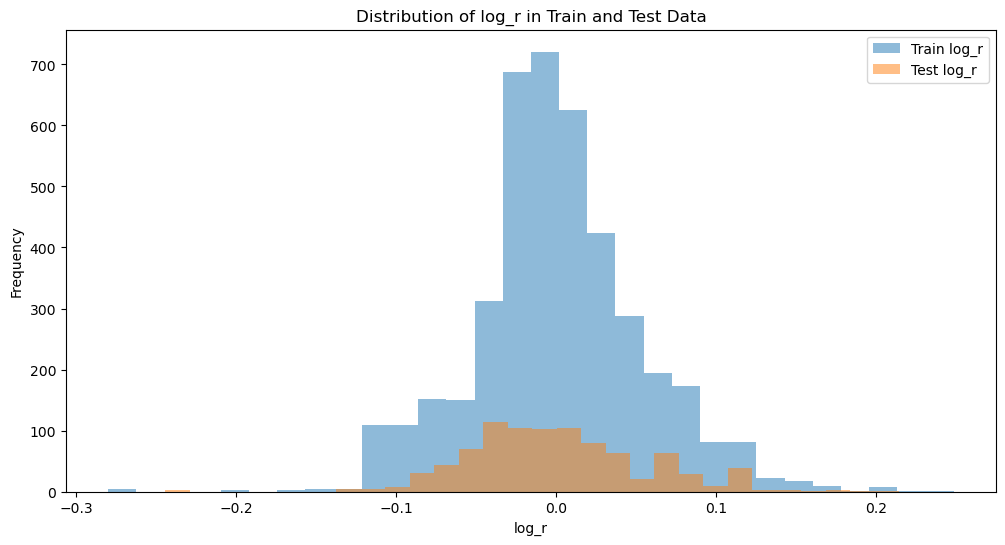

In [ ]:
# import json
# import pandas as pd
# from datetime import datetime, timedelta
# import matplotlib.pyplot as plt
# import os

# # Load data
# with open('ft_data_2k_more_2_train.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

# # Convert to DataFrame for easier manipulation
# df = pd.DataFrame(data)

# # Convert the 'time' column to datetime
# df['time'] = pd.to_datetime(df['time'])

# # Sort by time
# df = df.sort_values(by='time')

# # Split the data: every 10th day goes to the test set
# start_date = df['time'].min()
# end_date = df['time'].max()
# test_dates = [start_date + timedelta(days=i*5) for i in range((end_date - start_date).days // 5 + 1)]

# test_data = df[df['time'].isin(test_dates)]
# train_data = df[~df['time'].isin(test_dates)]

# # Convert time column to string for JSON serialization
# train_data['time'] = train_data['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
# test_data['time'] = test_data['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# # Convert back to dictionary format
# train_data_dict = train_data.to_dict(orient='records')
# test_data_dict = test_data.to_dict(orient='records')

# # Create the directory if it doesn't exist
# os.makedirs('ft_data_2k_more_2', exist_ok=True)

# # Save the split data
# with open('ft_data_2k_more_2/train.json', 'w', encoding='utf-8') as f:
#     json.dump(train_data_dict, f, ensure_ascii=False, indent=4)
# with open('ft_data_2k_more_2/test.json', 'w', encoding='utf-8') as f:
#     json.dump(test_data_dict, f, ensure_ascii=False, indent=4)

# # Print log_r distribution
# print("Train log_r distribution:")
# print(train_data['log_r'].describe())

# print("\nTest log_r distribution:")
# print(test_data['log_r'].describe())

# # Print label counts in test data
# print("\nTest data label counts:")
# print(test_data['label'].value_counts())

# # Plot log_r distribution
# plt.figure(figsize=(12, 6))
# plt.hist(train_data['log_r'].astype(float), bins=30, alpha=0.5, label='Train log_r')
# plt.hist(test_data['log_r'].astype(float), bins=30, alpha=0.5, label='Test log_r')
# plt.xlabel('log_r')
# plt.ylabel('Frequency')
# plt.title('Distribution of log_r in Train and Test Data')
# plt.legend(loc='upper right')
# plt.show()

In [ ]:
# import json
# from sklearn.model_selection import train_test_split

# with open('ft_data_2k_more_train.json', 'r', encoding='utf-8') as f:
#     data = json.load(f)

# train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
# with open('ft_data_2k_more/train.json', 'w', encoding='utf-8') as f:
#     json.dump(train_data, f, ensure_ascii=False, indent=4)
# with open('ft_data_2k_more/test.json', 'w', encoding='utf-8') as f:
#     json.dump(test_data, f, ensure_ascii=False, indent=4)